<a href="https://colab.research.google.com/github/93gad/SA_RNN_TFKERAS/blob/main/SA_RNN_TFKERAS_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial.distance import cdist
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl 


# Импорт данных

In [2]:
!gdown --id 1E9QxPTYRLrVbUH5_-BDFs5-C7GWM-RMw
!gdown --id 1XWPoj3FMmizXa2uYss2x_aG4NVFBPEjp
!gdown --id 1bEc0H5TP6Oymz_GOBL2nltu486OuIfUj
!gdown --id 1bSsCL0BAguULsIaq3cTj4-guEba3FMe_

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1E9QxPTYRLrVbUH5_-BDFs5-C7GWM-RMw
To: /content/testdn (4).csv
100% 5.34M/5.34M [00:00<00:00, 237MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XWPoj3FMmizXa2uYss2x_aG4NVFBPEjp
To: /content/traindn (4).csv
100% 20.4M/20.4M [00:00<00:00, 215MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/

In [3]:
!gdown --id 1Dtj5ZWVwO75sdpvMi2yXIxIapm3j2lfm

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dtj5ZWVwO75sdpvMi2yXIxIapm3j2lfm
To: /content/best_model (1).h5
100% 1.05M/1.05M [00:00<00:00, 166MB/s]


In [4]:
df = pd.read_csv("traindn (4)tn2.csv")
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.apply(lambda x: x.str.strip().str.replace('\n', ' ') if x.dtype == "object" else x)
def clean_symbols(text):
    return re.sub(r'[^\w\s]|\d', '', text)
df = df.applymap(lambda x: clean_symbols(x) if type(x) == str else x)
df.to_csv("traindn (4)tn2.csv", index=False)

In [5]:
!ls

'best_model (1).h5'  'testdn (4).csv'	   'traindn (4)tn.csv'
 best_model.h5	     'traindn (4).csv'
 sample_data	     'traindn (4)tn2.csv'


#Подготовка данных

In [6]:
train = pd.read_csv('traindn (4)tn2.csv', 
                    header=None, 
                    names=['Review', 'Class'],)
test = pd.read_csv('testdn (4).csv', 
                    header=None, 
                    names=['Review', 'Class'],)

In [7]:
train

,Review,Class
0,досудебное расследование по факту покупки енпф...,0
1,во дворце мира и согласия астаны прошли два ме...,1
2,традиционный моноцентричный подход градостроит...,1
3,прессслужба национального бюро по противодейст...,0
4,мобильная версия шрифт астана января kazakhst...,0
...,...,...
3377,атфбанк в i полугодии увеличил активы по мсфо ...,1
3378,анна кобжесарова перед новым годом была ошараш...,0
3379,в алматинском городском суде в закрытом судебн...,0
3380,москва янв прайм крупнейший российский автоп...,1


In [8]:
x_train_text = train['Review']

In [9]:
x_test_text = test['Review']

In [11]:
print("Размер набора для обучения: ", len(x_train_text))
print("Размер набора для тестирования: ", len(x_test_text))

Размер набора для обучения:  3382
Размер набора для тестирования:  847


In [12]:
train['Class'].value_counts()
# Количество валидации в тренривочном наборе

1    2229
0    1153
Name: Class, dtype: int64

In [13]:
data_text = x_train_text + x_test_text

In [14]:
x_train_text[3381]

'с  по  год китай вложил в казахстан почти  млрд прямых инвестиций передает kazpravdakz со ссылкой на председателя правления kaznex invest борисбия жангуразова  инвестиционное сотрудничество казахстана и китая в последнее время быстро развивается с  по  год кнр вложила в казахстан почти  млрд прямых иностранных инвестиций по этому показателю китай входит в пятерку крупнейших иностранных инвесторов в казахстане  приводит сказанные жангуразовым в ходе бизнесфорума слова сайт primeministerkz как он отметил возможностей для взаимной торговли очень много экономики казахстана и китая могут быть комплементарными казахстан может поставлять в китай большое количество продуктов питания которые в китае сложно выращивать изза климатических условий мы также можем поставлять в китай определенные компоненты и сырье  сказал жангуразов вместе с тем руководитель компании отметил сотрудничество в рамках индустриальноинвестиционной программы сейчас она включает перечень из  проекта на сумму более  млрд по

In [15]:
train['Class'].fillna(0, inplace=True)
train['Class'] = train['Class'].astype(int)

In [16]:
y_train = train['Class'].astype(int)

In [17]:
test['Class'].fillna(0, inplace=True)
test['Class'] = test['Class'].astype(int)

In [18]:
y_test = test['Class'].astype(int)

In [19]:
y_train[1]

1

In [20]:
num_words = 10000

In [21]:
tokenizer = Tokenizer(num_words=num_words)

In [22]:
%%time

data_text = [data_text for data_text in data_text if isinstance(data_text, str)]
tokenizer.fit_on_texts(data_text)


CPU times: user 1.27 s, sys: 23.8 ms, total: 1.3 s
Wall time: 1.31 s


In [ ]:
tokenizer.word_index

In [24]:
x_train_text = [str(text) if isinstance(text, float) else text for text in x_train_text]


In [25]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)


In [26]:
x_train_text[1]

'во дворце мира и согласия астаны прошли два международных форума astana architecture и business  design dialogue и состоялась церемония награждения победителей национальной архитектурной премии architecture  design leaders на единой площадке форума собрались архитекторы дизайнеры девелоперы строители заказчики всего форум посетили около  человек насыщенная программа конференции дополнилась выставкой производителей и поставщиков мебели освещения напольных и потолочных покрытий строительных материалов технологий как современная архитектура может стать драйвером развития городов какие подходы и стратегии в девелопменте могут обеспечить комфортную городскую среду и сделать город интересным и притягательным для посещения какой международный опыт мог бы пригодиться астане эти и другие вопросы стали поводом для дискуссий и выступлений международных спикеров участники конференции обсудили актуальные вопросы в области дизайна и архитектуры поговорили о новых возможностях градостроительства рас

In [27]:
np.array(x_train_tokens[0])

array([1023,  636,    4,  643, 1591,   44, 5092,  676,   59,  367,  352,
         40, 1978,    4, 2835,  184,   73,   25,  181,  135,  186,  879,
        783,  792,    2,  493,  270,  389,   20, 1085, 1501, 3542,    9,
       2488, 1173,  327, 2444,  184,   73, 3196,   19,  202,    8,   40,
       2444,  184,   73,    1, 1766,  842,  219,  328, 1063, 6634, 3945,
       4862,  185,  928,  202,    8, 2011,    1, 1766,  842,   15,   38,
          6,   53, 1698,    3,   68, 5605, 1945,  590, 1024,  143, 1501,
        101,    1, 1475, 2106,    6,    7, 3543,    6,  327, 3542,    9,
       1321,   44,  101, 1300,  605, 1321,    1,   21,  749, 1108,  880,
        238,  353,  184,   73,  550,    6, 2107, 3197,    4, 2489,   21,
         44,    1,  240, 1135,  562,  246,   23,    1, 6283,    6,    4,
       3661,   44,    3,  154,    1,  484,   26, 1248,  322,    1, 1475,
          6, 1517, 5939,    7, 9456,  257,  908,  591,   74,  193, 1119,
       1322,    1, 2366, 1476,  100, 3012,    2, 15

In [28]:
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

In [29]:
num_tokens = np.array([len(tokens) for tokens in x_train_tokens + x_test_tokens])


In [30]:
np.mean(num_tokens)

353.3918183967841

In [31]:
np.max(num_tokens)

7514

In [32]:
np.min(num_tokens)

5

## Визуализация длины токена

In [33]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

1450

In [34]:
str(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100) +' %' 

'96.71317096240246 %'

In [35]:
pad = 'pre'

In [36]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [37]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

In [38]:
x_train_pad.shape

(3382, 1450)

In [39]:
x_test_pad.shape

(847, 1450)

In [40]:
np.array(x_train_tokens[1])

array([  89, 8712,  308,    2, 5093,  194,  868,  161,  399,  741, 1592,
          2, 3544,    2,  920, 3093, 8713, 5606,   82, 1518,    3, 1565,
       3013,  741,   79, 2012, 3946,  190,  139,  516, 2684,  824,    2,
       4863, 9457,    2, 1323, 1005,  527,   14, 6635,  113,  477, 4104,
         39, 1120,  881, 4255,    2,  855,    1,  220,  407, 1653,    2,
        592, 1046, 9458,    2,    9, 5607, 1201,  765,  691, 1876,  123,
        172,  140,    2,  241,  242,  423,    9,    2, 8714,  399, 1286,
       2684, 2150, 3423,  242,    1,   34,    2,   16,   99, 7542,  808,
        115, 3662, 4648,   14,   65,  208,   43,    2,   65,  208, 9459,
          3,    1, 8080,   55, 3947,    2, 9459,  356,   11,   47,   13,
          2,   48,   33,  517,    3, 7543,    3,  562,  399, 2203, 2445,
       5608,    2,  256, 2836,  540, 4433,  929, 9460,    9,    2, 3424,
        661,    2, 1287,  142,    2, 3198, 2204,   65, 1288,   65, 7053,
       9460, 6636,  134,    1,  272, 3948, 3014, 33

In [41]:
np.array(x_train_pad[1])

array([  0,   0,   0, ..., 473, 317, 793], dtype=int32)

In [42]:
num_tokens_pad = np.concatenate((np.array([len(tokens) for tokens in x_train_pad]), 
                                 np.array([len(tokens) for tokens in x_test_pad])))


## Создание рекуррентной нейронной сети



In [43]:
model = Sequential()

In [44]:
embedding_size = 8

In [45]:
model.add(Embedding(input_dim=num_words,
                   output_dim=embedding_size,
                   input_length=max_tokens,
                   ))

In [46]:
model.add(GRU(units=16, return_sequences=True))

In [47]:
model.add(tf.keras.layers.Dropout(0.5))

In [48]:
model.add(GRU(units=8, return_sequences=True))

In [49]:
model.add(GRU(units=4))

In [50]:
model.add(Dense(1, activation='sigmoid'))\
#

In [51]:
optimizer = Adam(lr=1e-3)

In [52]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1450, 8)           80000     
                                                                 
 gru (GRU)                   (None, 1450, 16)          1248      
                                                                 
 dropout (Dropout)           (None, 1450, 16)          0         
                                                                 
 gru_1 (GRU)                 (None, 1450, 8)           624       
                                                                 
 gru_2 (GRU)                 (None, 4)                 168       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 82,045
Trainable params: 82,045
Non-traina

In [59]:
model_save_path = 'best_model (1).h5'
# checkpoint_callback = ModelCheckpoint(model_save_path, 
#                                       monitor='val_accuracy',
#                                       save_best_only=True,
#                                       verbose=1)

In [55]:
%%time
history=model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=5, batch_size=10, callbacks=[checkpoint_callback])

# one epoch = один прямой проход и один обратный проход всех обучающих примеров
# batch size = количество обучающих примеров за один прямой / обратный проход

Epoch 1/5
322/322 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.6750
Epoch 1: val_accuracy improved from -inf to 0.84706, saving model to best_model.h5
322/322 [==============================] - 35s 92ms/step - loss: 0.6191 - accuracy: 0.6750 - val_loss: 0.4003 - val_accuracy: 0.8471
Epoch 2/5
322/322 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8829
Epoch 2: val_accuracy improved from 0.84706 to 0.90588, saving model to best_model.h5
322/322 [==============================] - 29s 89ms/step - loss: 0.3271 - accuracy: 0.8829 - val_loss: 0.2790 - val_accuracy: 0.9059
Epoch 3/5
322/322 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9430
Epoch 3: val_accuracy did not improve from 0.90588
322/322 [==============================] - 28s 86ms/step - loss: 0.1851 - accuracy: 0.9430 - val_loss: 0.3429 - val_accuracy: 0.8588
Epoch 4/5
322/322 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9682
E

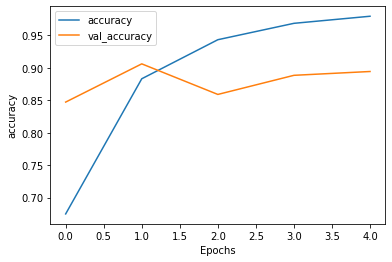

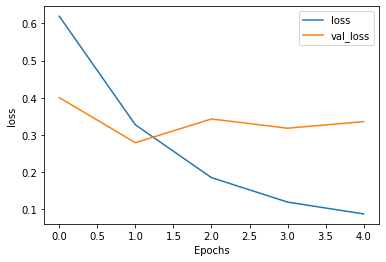

In [56]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [60]:
model.load_weights(model_save_path)

In [61]:
%%time
result = model.evaluate(x_test_pad, y_test)
print("Точность: {0:.2%}".format(result[1]))

27/27 [==============================] - 2s 59ms/step - loss: 0.3198 - accuracy: 0.8855
Точность: 88.55%
CPU times: user 1.56 s, sys: 27.8 ms, total: 1.59 s
Wall time: 2.63 s


In [ ]:
from google.colab import files
files.download('traindn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('testdn.csv')

In [62]:
review='''число жертв землетрясения в турции превысило  тысяч число жертв землетрясений с эпицентром в турецком кахраманмараше достигло   человек пострадали   жителей об этом сообщил президент турции реджеп тайип эрдоган передает миа казинформ со ссылкой на анадолукак заявил глава страны реджеп тайип эрдоган в поисковоспасательных и гуманитарных работах в  провинциях зоны бедствия задействованы более  тысячи человек включая спасателей изза рубежаглава государства выразил благодарность каждому кто вносит вклад в устранение последствий разрушительных землетрясений на юге странытурецкий лидер подчеркнул что государство готово к поддержке граждан пострадавших изза стихийного бедствияон призвал население зоны бедствия всецело доверять государству в вопросе устранения последствий землетрясенияпрезидент турции сообщил что домовладельцам разместившим семьи из зоны бедствия будет выплачиваться по  тысяч турецких лир в месяц а тем кто арендует жилье  по  тысячи лирмежду тем в турции начались судебные расследования в отношении тех кто строил здания и ответственных лиц в провинциях подвергшихся землетрясению об этом заявил министр юстиции бекир боздаг ознакомившийся со спасательными работами в районе баглар в диярбакыренапомним  февраля в районе пазарджык провинции кахраманмараш на юговостоке турции произошло землетрясение магнитудой  в десяти провинциях турции введен режим чп сроком на  дней президент реджеп тайип эрдоган объявил в турции семидневный общенациональный траур по жертвам стихийного бедствия государственные флаги турции приспущены на всей территории страныразрушительное землетрясение ощутили и в соседних странах в том числе в сирии ливане трск греческом кипре и ираке'''

tokens = tokenizer.texts_to_sequences([review])
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating='pre')
print(tokens_pad, tokens_pad.shape)
a=model.predict(tokens_pad)[0]
print('Тональность текста с оценкой {} '.format(a[0]))

[[  0   0   0 ... 107   1   2]] (1, 1450)
1/1 [==============================] - 3s 3s/step
Тональность текста с оценкой 0.07657155394554138 


# Проверка на неизвестных данных

In [ ]:
!gdown --id 1rJM2BuOyY4VdFo6oZ_Qu6fdRTWN4FVHq

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rJM2BuOyY4VdFo6oZ_Qu6fdRTWN4FVHq
To: /content/items_v2.csv
100% 2.92M/2.92M [00:00<00:00, 215MB/s]


In [ ]:
items = pd.read_csv('items_v2.csv', 
                    header=None, 
                    names=['Review', 'Class'],)

In [ ]:
items

,Review,Class
0,рост госпитализации больных c пневмонией отмеч...,1
1,долю в обслуживающем мусорный полигон предприя...,1
2,число жертв землетрясений в турции превысило ...,1
3,предотвратить подтопление города талыми водами...,1
4,банный комплекс загорелся изза утечки газа в а...,1
...,...,...
996,Уникальное месторождение подземных вод «Кокжид...,1
997,Касым-Жомарт Токаев подписал указ о создании Н...,1
998,Одиннадцать медалей завоевали казахстанские бо...,1
999,Сколько сел в Казахстане подключено к Интернет...,1


# Обработка

In [ ]:
%%time
import time
from multiprocessing import Process
import threading
from time import perf_counter

results = pd.DataFrame(columns=['Review','Class'])

def test_items(review):
    tokens = tokenizer.texts_to_sequences([str(review).lower()])
    tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                            padding=pad, truncating='pre')
    tokens_pad.shape
    a = model.predict(tokens_pad)[0]
    print(a,review)

if __name__ == '__main__':
  start_time = perf_counter()
  for review in items['Review']:
    test_items(review)
  
  end_time = perf_counter()
  print(end_time - start_time)


1/1 [==============================] - 0s 157ms/step
[0.28897545] рост госпитализации больных c пневмонией отмечается в акмолинской области по сравнению с прошлым эпидемическим сезоном в акмолинской области отмечается рост госпитализации при заболевании пневмонией на  об этом сообщил на прошедшем брифинге заместитель главного государственного санитарного врача акмолинской области серик омарханов передает корреспондент миа казинформпо словам спикера по сравнению с прошлым эпидемическим сезоном с начала эпидсезона  годов отмечается рост заболеваемости орви гриппом в  раза зарегистрировано   случаев орвигриппа при этом удельный вес заболевших детей составил  зарегистрировано   случаев в том числе до  лет    с  лет    среди беременных зарегистрировано  случая орвитяжелым осложнением респираторных заболеваний является пневмония с начала текущего эпидемического сезона госпитализировали  лицо с пневмонией в том числе  детей до  лет среди них  детей  до  года по сравнению с прошлым эпидемическ

# Многопроцессорная обработка

In [ ]:
%%time
import time
from multiprocessing import Process
import threading
from time import perf_counter

results = pd.DataFrame(columns=['Review','Class'])

def test_items(review):
    tokens = tokenizer.texts_to_sequences([str(review).lower()])
    tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                            padding=pad, truncating='pre')
    tokens_pad.shape
    a = model.predict(tokens_pad)[0]
    print(a, review)

if __name__ == '__main__':
    start_time = perf_counter()
    processes = []
    for review in items['Review']:
        p = Process(target=test_items, args=(review,))
        processes.append(p)
        p.start()
        
    for process in processes:
        process.join()
    
    end_time = perf_counter()
    print(end_time - start_time)



58.09309039599975
CPU times: user 1.54 s, sys: 41.2 s, total: 42.8 s
Wall time: 58.1 s
